<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dropout, Dense, Bidirectional
from keras.layers import Dense, LSTM, Embedding, Dropout

import spacy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Cargar el dataset
df = pd.read_csv('./simpsons_dataset.csv')
df = df[['spoken_words']]
df.rename(columns={'spoken_words': 0}, inplace=True)
print(df.head())

                                                   0
0  No, actually, it was a little of both. Sometim...
1                             Where's Mr. Bergstrom?
2  I don't know. Although I'd sure like to talk t...
3                         That life is worth living.
4  The polls will be open from now until the end ...


In [3]:
# Los valores faltantes provienen de la parte del guion donde sucede algo, pero sin diálogo
df.isnull().sum()

0    26459
dtype: int64

In [4]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

0    0
dtype: int64

In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 131855


In [6]:
# Me quedo con las primeras 15000 lineas porque no tengo MemoryError mas adelante
df = df.head(15000)
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 15000


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [7]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [8]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

"No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it."

In [9]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['no',
 'actually',
 'it',
 'was',
 'a',
 'little',
 'of',
 'both',
 'sometimes',
 'when',
 'a',
 'disease',
 'is',
 'in',
 'all',
 'the',
 'magazines',
 'and',
 'all',
 'the',
 'news',
 'shows',
 "it's",
 'only',
 'natural',
 'that',
 'you',
 'think',
 'you',
 'have',
 'it']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [10]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [11]:
# Demos un vistazo
sentence_tokens[:2]

[['no',
  'actually',
  'it',
  'was',
  'a',
  'little',
  'of',
  'both',
  'sometimes',
  'when',
  'a',
  'disease',
  'is',
  'in',
  'all',
  'the',
  'magazines',
  'and',
  'all',
  'the',
  'news',
  'shows',
  "it's",
  'only',
  'natural',
  'that',
  'you',
  'think',
  'you',
  'have',
  'it'],
 ["where's", 'mr', 'bergstrom']]

In [12]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [13]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['no', 'actually', 'it', 'was'],
 ['actually', 'it', 'was', 'a'],
 ['it', 'was', 'a', 'little'],
 ['was', 'a', 'little', 'of'],
 ['a', 'little', 'of', 'both'],
 ['little', 'of', 'both', 'sometimes'],
 ['of', 'both', 'sometimes', 'when'],
 ['both', 'sometimes', 'when', 'a'],
 ['sometimes', 'when', 'a', 'disease'],
 ['when', 'a', 'disease', 'is'],
 ['a', 'disease', 'is', 'in'],
 ['disease', 'is', 'in', 'all'],
 ['is', 'in', 'all', 'the'],
 ['in', 'all', 'the', 'magazines'],
 ['all', 'the', 'magazines', 'and'],
 ['the', 'magazines', 'and', 'all'],
 ['magazines', 'and', 'all', 'the'],
 ['and', 'all', 'the', 'news'],
 ['all', 'the', 'news', 'shows'],
 ['the', 'news', 'shows', "it's"],
 ['news', 'shows', "it's", 'only'],
 ['shows', "it's", 'only', 'natural'],
 ["it's", 'only', 'natural', 'that'],
 ['only', 'natural', 'that', 'you'],
 ['natural', 'that', 'you', 'think'],
 ['that', 'you', 'think', 'you'],
 ['you', 'think', 'you', 'have']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [14]:
tok = Tokenizer() 

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [15]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[25, 24, 22, 5],
 [24, 22, 5, 1],
 [22, 5, 1, 6],
 [5, 1, 6, 7],
 [1, 6, 7, 8],
 [6, 7, 8, 9],
 [7, 8, 9, 10],
 [8, 9, 10, 1],
 [9, 10, 1, 11],
 [10, 1, 11, 12],
 [1, 11, 12, 13],
 [11, 12, 13, 2],
 [12, 13, 2, 3],
 [13, 2, 3, 14],
 [2, 3, 14, 15],
 [3, 14, 15, 2],
 [14, 15, 2, 3],
 [15, 2, 3, 16],
 [2, 3, 16, 17],
 [3, 16, 17, 18],
 [16, 17, 18, 19],
 [17, 18, 19, 20],
 [18, 19, 20, 21],
 [19, 20, 21, 4],
 [20, 21, 4, 23],
 [21, 4, 23, 4],
 [4, 23, 4, 26]]

In [16]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

27


In [17]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

26


In [18]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'a': 1, 'all': 2, 'the': 3, 'you': 4, 'was': 5, 'little': 6, 'of': 7, 'both': 8, 'sometimes': 9, 'when': 10, 'disease': 11, 'is': 12, 'in': 13, 'magazines': 14, 'and': 15, 'news': 16, 'shows': 17, "it's": 18, 'only': 19, 'natural': 20, 'that': 21, 'it': 22, 'think': 23, 'actually': 24, 'no': 25, 'have': 26}


In [19]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'it': 3, 'actually': 2, 'no': 1, 'was': 4, 'a': 8, 'little': 4, 'of': 4, 'both': 4, 'sometimes': 4, 'when': 4, 'disease': 4, 'is': 4, 'in': 4, 'all': 8, 'the': 8, 'magazines': 4, 'and': 4, 'news': 4, 'shows': 4, "it's": 4, 'only': 4, 'natural': 4, 'that': 4, 'you': 4, 'think': 3, 'have': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [20]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     No, actually, it was a little of both. Sometim...
1                                Where's Mr. Bergstrom?
2     I don't know. Although I'd sure like to talk t...
3                            That life is worth living.
4     The polls will be open from now until the end ...
5           I don't think there's anything left to say.
6                                                 Bart?
7                        Victory party under the slide!
8                         Mr. Bergstrom! Mr. Bergstrom!
9     Hey, hey, he Moved out this morning. He must h...
10                  Do you know where I could find him?
11    I think he's taking the next train to Capital ...
12    The train, how like him... traditional, yet en...
13    Yes, and it's been the backbone of our country...
14                           I see he touched you, too.
15                      Hey, thanks for your vote, man.
Name: 0, dtype: object

In [21]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it\'s only natural that you think you have it. Where\'s Mr. Bergstrom? I don\'t know. Although I\'d sure like to talk to him. He didn\'t touch my lesson plan. What did he teach you? That life is worth living. The polls will be open from now until the end of recess. Now, just in case any of you have decided to put any thought into this, we\'ll have our final statements. Martin? I don\'t think there\'s anything left to say. Bart? Victory party under the slide! Mr. Bergstrom! Mr. Bergstrom! Hey, hey, he Moved out this morning. He must have a new job -- he took his Copernicus costume. Do you know where I could find him? I think he\'s taking the next train to Capital City. The train, how like him... traditional, yet environmentally sound. Yes, and it\'s been the backbone of our country since Leland Stanford drove that golden spike at Promontory point. I see he touched you, too. H

In [22]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['no',
 'actually',
 'it',
 'was',
 'a',
 'little',
 'of',
 'both',
 'sometimes',
 'when',
 'a',
 'disease',
 'is',
 'in',
 'all',
 'the',
 'magazines',
 'and',
 'all',
 'the']

In [23]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 143181


In [24]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [25]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['no', 'actually', 'it', 'was'],
 ['actually', 'it', 'was', 'a'],
 ['it', 'was', 'a', 'little'],
 ['was', 'a', 'little', 'of'],
 ['a', 'little', 'of', 'both'],
 ['little', 'of', 'both', 'sometimes'],
 ['of', 'both', 'sometimes', 'when'],
 ['both', 'sometimes', 'when', 'a'],
 ['sometimes', 'when', 'a', 'disease'],
 ['when', 'a', 'disease', 'is'],
 ['a', 'disease', 'is', 'in'],
 ['disease', 'is', 'in', 'all'],
 ['is', 'in', 'all', 'the'],
 ['in', 'all', 'the', 'magazines'],
 ['all', 'the', 'magazines', 'and'],
 ['the', 'magazines', 'and', 'all'],
 ['magazines', 'and', 'all', 'the'],
 ['and', 'all', 'the', 'news'],
 ['all', 'the', 'news', 'shows'],
 ['the', 'news', 'shows', "it's"]]

In [26]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[24, 373, 8, 36],
 [373, 8, 36, 4],
 [8, 36, 4, 65],
 [36, 4, 65, 7],
 [4, 65, 7, 571],
 [65, 7, 571, 811],
 [7, 571, 811, 88],
 [571, 811, 88, 4],
 [811, 88, 4, 3091],
 [88, 4, 3091, 12],
 [4, 3091, 12, 11],
 [3091, 12, 11, 26],
 [12, 11, 26, 1],
 [11, 26, 1, 2548],
 [26, 1, 2548, 6],
 [1, 2548, 6, 26],
 [2548, 6, 26, 1],
 [6, 26, 1, 496],
 [26, 1, 496, 1546],
 [1, 496, 1546, 30]]

In [27]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 143177


### 3 - Input y target

In [28]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(143177, 3)
(143177,)


In [29]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'you',
 3: 'i',
 4: 'a',
 5: 'to',
 6: 'and',
 7: 'of',
 8: 'it',
 9: 'my',
 10: 'that',
 11: 'in',
 12: 'is',
 13: 'this',
 14: 'me',
 15: 'your',
 16: 'for',
 17: 'oh',
 18: "i'm",
 19: 'on',
 20: 'we',
 21: 'what',
 22: 'have',
 23: 'be',
 24: 'no',
 25: "don't",
 26: 'all',
 27: 'do',
 28: 'well',
 29: 'but',
 30: "it's",
 31: 'with',
 32: 'just',
 33: 'homer',
 34: 'now',
 35: 'are',
 36: 'was',
 37: 'get',
 38: 'like',
 39: 'hey',
 40: 'can',
 41: 'not',
 42: 'know',
 43: 'so',
 44: 'one',
 45: 'bart',
 46: "you're",
 47: 'up',
 48: 'right',
 49: 'at',
 50: 'here',
 51: "that's",
 52: 'if',
 53: 'out',
 54: 'he',
 55: 'go',
 56: 'good',
 57: 'uh',
 58: 'got',
 59: 'how',
 60: 'think',
 61: "i'll",
 62: 'our',
 63: 'there',
 64: 'marge',
 65: 'little',
 66: 'yeah',
 67: 'about',
 68: 'see',
 69: 'want',
 70: 'dad',
 71: 'man',
 72: 'as',
 73: 'simpson',
 74: 'from',
 75: 'will',
 76: 'come',
 77: 'time',
 78: 'they',
 79: 'him',
 80: 'look',
 81: 'an',
 82: 'his',
 

In [30]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

12296

In [31]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size)

IndexError: index 12296 is out of bounds for axis 1 with size 12296

In [32]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [33]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(143177, 12296)

### 4 - Entrenar el modelo

In [34]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [35]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

12296

In [246]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3, 5)              61485     
                                                                 
 lstm_6 (LSTM)               (None, 3, 64)             17920     
                                                                 
 dropout_3 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 12296)             405768    
                                                                 
Total params: 520277 (1.98 MB)
Trainable params: 52027

In [247]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
3580/3580 [==============================] - 65s 15ms/step - loss: 7.0183 - accuracy: 0.0324 - val_loss: 6.9922 - val_accuracy: 0.0339
Epoch 2/50
3580/3580 [==============================] - 54s 15ms/step - loss: 6.6437 - accuracy: 0.0403 - val_loss: 7.0361 - val_accuracy: 0.0425
Epoch 3/50
3580/3580 [==============================] - 55s 15ms/step - loss: 6.4096 - accuracy: 0.0485 - val_loss: 7.0318 - val_accuracy: 0.0494
Epoch 4/50
3580/3580 [==============================] - 56s 16ms/step - loss: 6.2416 - accuracy: 0.0566 - val_loss: 7.0775 - val_accuracy: 0.0557
Epoch 5/50
3580/3580 [==============================] - 69s 19ms/step - loss: 6.1043 - accuracy: 0.0644 - val_loss: 7.1115 - val_accuracy: 0.0592
Epoch 6/50
3580/3580 [==============================] - 64s 18ms/step - loss: 5.9744 - accuracy: 0.0721 - val_loss: 7.1863 - val_accuracy: 0.0672
Epoch 7/50
3580/3580 [==============================] - 60s 17ms/step - loss: 5.8556 - accuracy: 0.0802 - val_loss: 7.2404 -

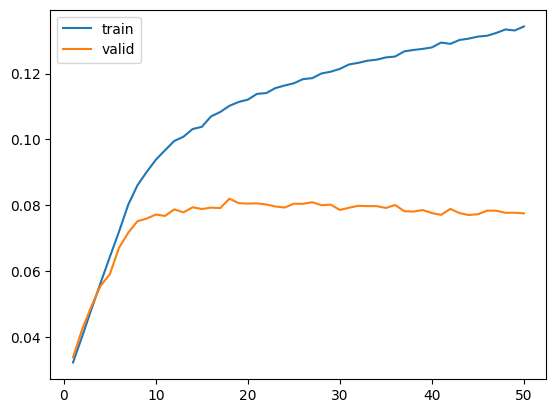

In [248]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [36]:
model_2 = Sequential()

# Embedding:
# input_seq_len = 5 --> ingreso 5 palabras
# input_dim = vocab_size --> 1204 palabras distintas
# output_dim = 13 --> crear embeddings de tamaño 5 (tamaño variable y ajustable) - (Surd[1204,4]= 5.9)
model_2.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model_2.add(Bidirectional(GRU(128, return_sequences=True)))
model_2.add(Dropout(0.2))
model_2.add(Bidirectional(GRU(128))) # La última capa LSTM no lleva return_sequences
model_2.add(Dense(64, activation='relu'))
#model.add(Dense(64, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 30459 palabras posibles
model_2.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              61485     
                                                                 
 bidirectional (Bidirection  (None, 3, 256)            103680    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 3, 256)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 12296)             7

In [39]:
hist_2 = model_2.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
3580/3580 [==============================] - 119s 32ms/step - loss: 6.5649 - accuracy: 0.0479 - val_loss: 6.8439 - val_accuracy: 0.0499
Epoch 2/50
3580/3580 [==============================] - 94s 26ms/step - loss: 6.2419 - accuracy: 0.0658 - val_loss: 6.8490 - val_accuracy: 0.0696
Epoch 3/50
3580/3580 [==============================] - 106s 30ms/step - loss: 5.9864 - accuracy: 0.0829 - val_loss: 6.9153 - val_accuracy: 0.0744
Epoch 4/50
3580/3580 [==============================] - 93s 26ms/step - loss: 5.7948 - accuracy: 0.0931 - val_loss: 7.0395 - val_accuracy: 0.0789
Epoch 5/50
3580/3580 [==============================] - 99s 28ms/step - loss: 5.6423 - accuracy: 0.0993 - val_loss: 7.1313 - val_accuracy: 0.0815
Epoch 6/50
3580/3580 [==============================] - 91s 25ms/step - loss: 5.5136 - accuracy: 0.1041 - val_loss: 7.1884 - val_accuracy: 0.0842
Epoch 7/50
3580/3580 [==============================] - 94s 26ms/step - loss: 5.4017 - accuracy: 0.1083 - val_loss: 7.4067

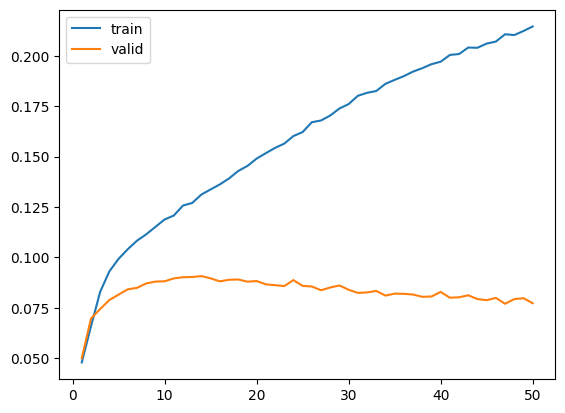

In [41]:
# Entrenamiento
epoch_count = range(1, len(hist_2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist_2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist_2.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 13s 13s/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

#### Modelo 1

In [43]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [270]:
input_text='hi homer'

generate_seq(model, tok, input_text, max_length=3, n_words=10)

1/1 [==============================] - 0s 20ms/step


'hi homer you no know you hey you not how a five'

In [262]:
input_text='lisa needs'

generate_seq(model, tok, input_text, max_length=3, n_words=3)

1/1 [==============================] - 0s 19ms/step


'lisa needs the general maiden'

In [263]:
input_text='i call the big one'

generate_seq(model, tok, input_text, max_length=5, n_words=3)

1/1 [==============================] - 0s 20ms/step


'i call the big one and you what'

In [264]:
input_text='monorail'

generate_seq(model, tok, input_text, max_length=3, n_words=3)

1/1 [==============================] - 0s 21ms/step


'monorail modesty you uh'

In [271]:
input_text='hi bart'

generate_seq(model, tok, input_text, max_length=3, n_words=10)

1/1 [==============================] - 0s 21ms/step


'hi bart you no you not get a marge a old had'

#### Modelo 2

In [44]:
input_text='hi homer'

generate_seq(model_2, tok, input_text, max_length=3, n_words=10)

1/1 [==============================] - 2s 2s/step


'hi homer you not okay you not win    '

In [45]:
input_text='lisa needs'

generate_seq(model_2, tok, input_text, max_length=3, n_words=3)

1/1 [==============================] - 2s 2s/step


'lisa needs star to the'

In [46]:
input_text='i call the big one'

generate_seq(model_2, tok, input_text, max_length=5, n_words=3)

1/1 [==============================] - 2s 2s/step


'i call the big one spirit in i'

In [47]:
input_text='monorail'

generate_seq(model_2, tok, input_text, max_length=3, n_words=3)

1/1 [==============================] - 1s 1s/step


'monorail buying  '

In [48]:
input_text='hi bart'

generate_seq(model_2, tok, input_text, max_length=3, n_words=10)

1/1 [==============================] - 0s 25ms/step


'hi bart you not win       '

### 7 - Beam search y muestreo aleatorio

In [273]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=3):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [274]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0] 

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens) 

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update)) 

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens) 

    return history_tokens

In [287]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="dental plan")

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 20ms/step


In [288]:
# veamos las salidas
decode(salidas[0])

['dental plan you over orleans land our']

### 8 - Conclusiones
El modelo entrenado tuvo un muy mal desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.